In [1]:
"""
Template for week 10 project in Data Visualization

Compute closest pairs of points using both slow and fast method
Compare running times of both methods on random sets of points
Compute hierarchical clustering using closest pair code
"""

import time
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import project10_provided as provided

In [2]:
# Resources paths
DATA_PATH = "data/"

# Set global flags
SAVE_PLOTS = False

In [3]:
######################################################
# Provided code for computing distance between two clusters


def pair_distance(cluster_list, idx1, idx2):
    """
    Input: List cluster_list of clusters, integers idx1, idx2
    
    Output: Tuple (dist, idx1, idx2) where dist is distance between
    cluster_list[idx1] and cluster_list[idx2].
    
    Notes: Returned tuple always has idx1 < idx2. 
    """
    return (cluster_list[idx1].distance(cluster_list[idx2]), min(idx1, idx2), max(idx1, idx2))

# Helper function
def min_distance(tuple1, tuple2):
    """
    helper function to determine which tuple distance is smaller and returns that tuple
    tuples have form (distance, idx1, idx2)
    """
    if tuple1[0] < tuple2[0]:
        return tuple1
    else:
        return tuple2

In [4]:
###################################################################
# Part 1 - Compute closest pairs using brute-force and divide-and-conquer

def slow_closest_pair(cluster_list):
    """
    Input: List cluster_list of clusters
    
    Output: Tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] have minimum distance dist.
    
    Notes: Returned tuple always has idx1 < idx2. Implements O(n^2) time algorithm.
    """
    closest_pair = (float('inf'), -1, -1)
    for u_idx in range(len(cluster_list)):
        for v_idx in range(u_idx + 1, len(cluster_list)):
            dist = pair_distance(cluster_list, u_idx, v_idx)  
            closest_pair = min_distance(closest_pair, dist)
    return closest_pair


In [4]:
def fast_closest_pair(sorted_cluster_list):
    """
    Input: List sorted_cluster_list of clusters SORTED SUCH THAT THE HORIZONTAL POSIIONS
    OF THEIR CENTERS ARE IN ASCENDING ORDER
    
    Output: Tuple of the form (dist, idx1, idx2) where the centers of the clusters
    sorted_cluster_list[idx1] and sorted_cluster_list[idx2] have minimum distance dist.
    
    Note: Returned tuple always has idx1 < idx2. Implements O(n log(n)^2) algorithm
    """
    num = len(sorted_cluster_list)
    
    if num <= 3:
        return slow_closest_pair(sorted_cluster_list) 

    # Divide
    mid = num // 2
    left_half = sorted_cluster_list[:mid]
    right_half = sorted_cluster_list[mid:]
    
    (dist_left, idx1_left, idx2_left) = fast_closest_pair(left_half)
    (dist_right, idx1_right, idx2_right) = fast_closest_pair(right_half)
    
    idx1_right += mid
    idx2_right += mid
    
    dist_min, idx1, idx2 = min((dist_left, idx1_left, idx2_left), 
                               (dist_right, idx1_right, idx2_right), key=lambda x: x[0])
    
    mid_x = (sorted_cluster_list[mid - 1].horiz_center() + 
             sorted_cluster_list[mid].horiz_center()) / 2
    (dist_strip, idx1_strip, idx2_strip) = closest_pair_strip(sorted_cluster_list, 
                                                              mid_x, dist_min)
    
    return min((dist_min, idx1, idx2), (dist_strip, idx1_strip, idx2_strip), key=lambda x: x[0])


In [4]:
def closest_pair_strip(cluster_list, horiz_center, half_width):
    """
    Input: List cluster_list of clusters,
    float horiz_center is the horizontal position of the strip's vertical center line
    float half_width is the half the width of the strip (i.e; the maximum horizontal distance
    that a cluster can lie from the center line)

    Output: Tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] lie in the strip and have minimum distance dist.
    
    NOTE: Returned tuple always has idx1 < idx2. Implements O(n log(n)) algorithm.
    """
    strip_clusters = [idx for idx in range(len(cluster_list)) 
                      if abs(cluster_list[idx].horiz_center() - horiz_center) < half_width]
    
    strip_clusters.sort(key=lambda idx: cluster_list[idx].vert_center())
    closest_pair = (float("inf"), -1, -1)

    for idx in range(len(strip_clusters)-1):
        for idx2 in range(idx + 1, min(idx+4, len(strip_clusters))):
            distance = pair_distance(cluster_list, strip_clusters[idx], strip_clusters[idx2])
            closest_pair = min_distance(closest_pair, distance)
    
    return closest_pair
    


In [34]:
# Small tests cases for all three functions from Coursesa class - remove closest_pair_strip from template
TEST_DATA = [[[0, 0], [1, 0]],			# base case
            [[1.1, 0], [1, 0.8]],		# base case
            [[0, 0], [0, 1], [0, 2]],	        # base case
            [[0, 0], [1, 1], [3, 2]],	        # base case
            [[0, 0], [1, 1], [2, 2]],	        # base case
            [[row, col] for row in range(4) for col in range(1)], 	# uniform vertical line
            [[row, col] for row in range(1) for col in range(4)], 	# unifomr horizontal line
            [[row, col] for row in range(2) for col in range(2)], 	# grid
            [[row, col] for row in range(-1, 2) for col in range(-1, 2)], 	# grid
            [[1.0, 0.0], [5.0, 0.0], [4.0, 0.0], [7.0, 0.0]],            
            [[1.0, 1.0], [1.0, 5.0], [1.0, 4.0], [1.0, 7.0]],            # sort in x, but unsorted in y
             
            [[0.7, 0.24], [0.1, 0.42], [0.33, 0.39], [0.21, 0.51]],      # always returns default tuple
            [[0.02, 1.0], [0.02, 0.74], [0.1, 0.11], [0.44, 0.12], [0.61, 0.7]],   # failed to compute inverse indices
            [[0.5, 0.2], [0.09, 0.07], [0.72, 0.08], [0.97, 0.09], [0.07, 0.29], [0.88, 0.94]],  # strip is everything
            [[0.11, 0.75], [0.62, 0.86], [0.65, 0.68], [0.68, 0.48], [0.7, 0.9], [0.79, 0.18]],  # additional test based on student failures
            [[0.38, 0.26], [0.42, 0.03], [0.48, 0.23], [0.8, 0.65], [0.95, 0.85], [0.97, 0.61]], # additional test based on student failures
            [[0.61, 0.8], [0.54, 0.8], [0.76, 0.94], [0.39, 0.4], [0.32, 0.16]],   # strip is too wide
            [[0.23, 0.94], [0.91, 0.6], [0.65, 0.08], [0.94, 0.9], [0.66, 0.43]],  # strip is too narrow
            [[0.53, 0.24], [0.95, 0.85], [0.6, 0.42], [0.57, 0.32], [0.37, 0.28]], # strip is empty
            [[0.66, 0.63], [0.7, 0.68], [0.78, 0.63], [0.1, 0.9], [0.9, 0.05]],    # failed to iterate over last element in outer loop
            [[0.87, 0.63], [0.37, 0.81], [0.7, 0.59], [0.73, 0.9], [0.1, 0.16]],   # failed to iterate over last element in inner loop
            [[0.74, 0.9], [0.03, 0.69], [0.76, 0.92], [0.16, 0.09], [0.13, 0.34]], # cluster_list in place strip
            [[-4.0, 0.0], [0.0, -1.0], [0.0, 1.0], [4.0, 0.0]],                    # closest pair in strip are three apart
            [[-1.0, 0.0], [-0.99, -10.0], [-0.98, -20.0], [0.98, 20.0], [0.99, 10.0], [1.0, 0.0]], # catches failure to sort strip
            [[-4.0, 0.0], [-2.0, 0.0], [0.0, -0.1], [0.0, 0.1], [2.0, 0.0], [4.0, 0.0]],    #failure to extract distance from divide part
            [[0.89, 0.28], [0.34, 0.57], [0.26, 0.92], [0.35, 0.15], [0.05, 0.11], [0.6, 0.41]], # strip_center = (left_list[-1].horiz_center() + right_list[1].horiz_center()) / 2.0
            [[0.68, 0.48], [0.65, 0.68], [0.7, 0.9], [0.11, 0.75], [0.62, 0.86], [0.79, 0.18]],  # NEW - for idx2 in range(idx1 + 1, min(4, len(strip))):
            [[0.38, 0.26], [0.48, 0.23], [0.42, 0.03], [0.95, 0.85], [0.8, 0.65], [0.97, 0.61]], # NEW - improper split in fast_closest_pairs, first one short
            [[0.02, 0.39], [0.19, 0.75], [0.35, 0.03], [0.73, 0.81], [0.76, 0.88], [0.78, 0.11]],
            [[-1.0, 0.1], [-1.0, -0.1], [0.0, 0.0], [1.0, 0.1], [1.0, -0.1]]] # NEW - improper split in fast_closest_pairs

# Note that some test cases have points with unsorted x-coordinates
for pts in TEST_DATA:
    new_pts = pts[:]
    new_pts.sort(key=lambda pt: pt[0])
    if pts != new_pts:
        print(pts, "has unsorted x-corodinates")

[[1.1, 0], [1, 0.8]] has unsorted x-corodinates
[[1.0, 0.0], [5.0, 0.0], [4.0, 0.0], [7.0, 0.0]] has unsorted x-corodinates
[[0.7, 0.24], [0.1, 0.42], [0.33, 0.39], [0.21, 0.51]] has unsorted x-corodinates
[[0.5, 0.2], [0.09, 0.07], [0.72, 0.08], [0.97, 0.09], [0.07, 0.29], [0.88, 0.94]] has unsorted x-corodinates
[[0.61, 0.8], [0.54, 0.8], [0.76, 0.94], [0.39, 0.4], [0.32, 0.16]] has unsorted x-corodinates
[[0.23, 0.94], [0.91, 0.6], [0.65, 0.08], [0.94, 0.9], [0.66, 0.43]] has unsorted x-corodinates
[[0.53, 0.24], [0.95, 0.85], [0.6, 0.42], [0.57, 0.32], [0.37, 0.28]] has unsorted x-corodinates
[[0.66, 0.63], [0.7, 0.68], [0.78, 0.63], [0.1, 0.9], [0.9, 0.05]] has unsorted x-corodinates
[[0.87, 0.63], [0.37, 0.81], [0.7, 0.59], [0.73, 0.9], [0.1, 0.16]] has unsorted x-corodinates
[[0.74, 0.9], [0.03, 0.69], [0.76, 0.92], [0.16, 0.09], [0.13, 0.34]] has unsorted x-corodinates
[[0.89, 0.28], [0.34, 0.57], [0.26, 0.92], [0.35, 0.15], [0.05, 0.11], [0.6, 0.41]] has unsorted x-corodinates

In [35]:
def test_closest_pair_functions():
    """ Build some tests for closest pair functions """
    
    for pts in TEST_DATA:
        cluster_list = [provided.Cluster(set([]), pt[0], pt[1], 1, 0) for pt in pts]
        slow_closest_pair(cluster_list)

    for pts in TEST_DATA:
        cluster_list = [provided.Cluster(set([]), pt[0], pt[1], 1, 0) for pt in pts]
        cluster_list.sort(key=lambda cluster: cluster.horiz_center())
        fast_closest_pair(cluster_list)

    
test_closest_pair_functions()

In [36]:
######################################################################
# Part 2 - Compute and plot hierarchical clusterings

def hierarchical_clustering(cluster_list, num_clusters):
    """
    Input: List cluster_list of clusters, interger num_clusters
    
    Output: List of clusters whose length is num_clusters
    
    NOTE: Function should mutate cluster_list to improve efficiency
    """
    
    while len(cluster_list) > num_clusters:
        cluster_list.sort(key=lambda cluster: cluster.horiz_center())
        _, idx1, idx2 = fast_closest_pair(cluster_list)
        cluster_list[idx1].merge_clusters(cluster_list[idx2])
        del cluster_list[idx2]
        
    return cluster_list

In [37]:
def test_hierarchical_clustering():
    """ Build tests for hierarchical_clustering() """
    
    risk_frame_24 = provided.risk_csv_to_dataframe(provided.DATA_24)
    for num_clusters in range(2, 24):
        singleton_clusters = provided.dataframe_to_singleton_clusters(risk_frame_24)
        hierarchical_clustering(singleton_clusters, num_clusters)

    risk_frame_111 = provided.risk_csv_to_dataframe(provided.DATA_111)
    for num_clusters in [110, 100, 80, 60, 40]:
        singleton_clusters = provided.dataframe_to_singleton_clusters(risk_frame_111)
        hierarchical_clustering(singleton_clusters, num_clusters)
    
    risk_frame_290 = provided.risk_csv_to_dataframe(provided.DATA_290)
    for num_clusters in [289, 250, 200, 100, 50]:
        singleton_clusters = provided.dataframe_to_singleton_clusters(risk_frame_290)
        hierarchical_clustering(singleton_clusters, num_clusters)

test_hierarchical_clustering()

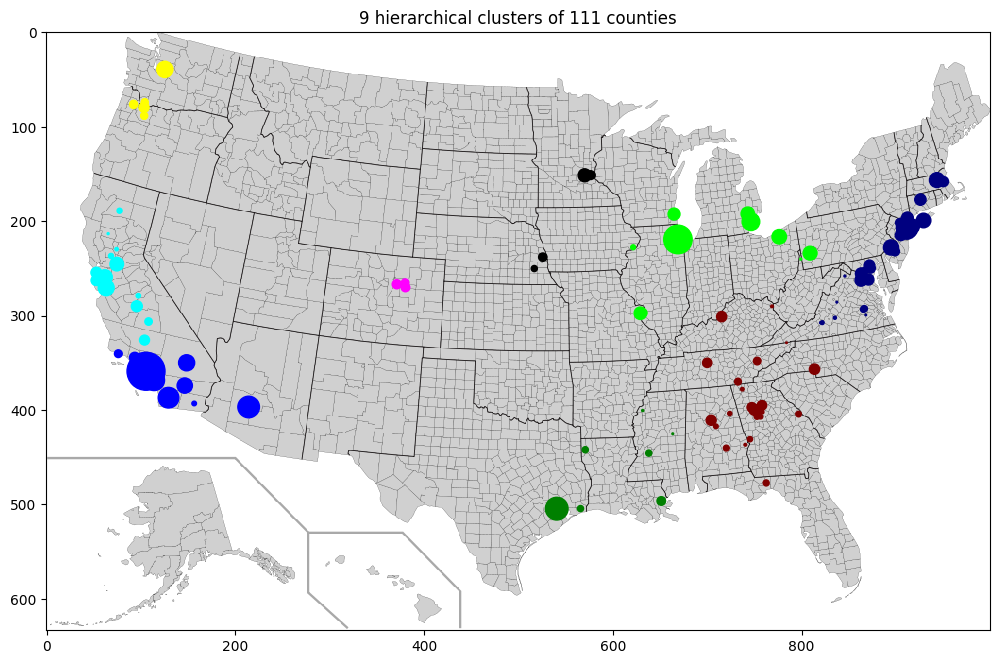

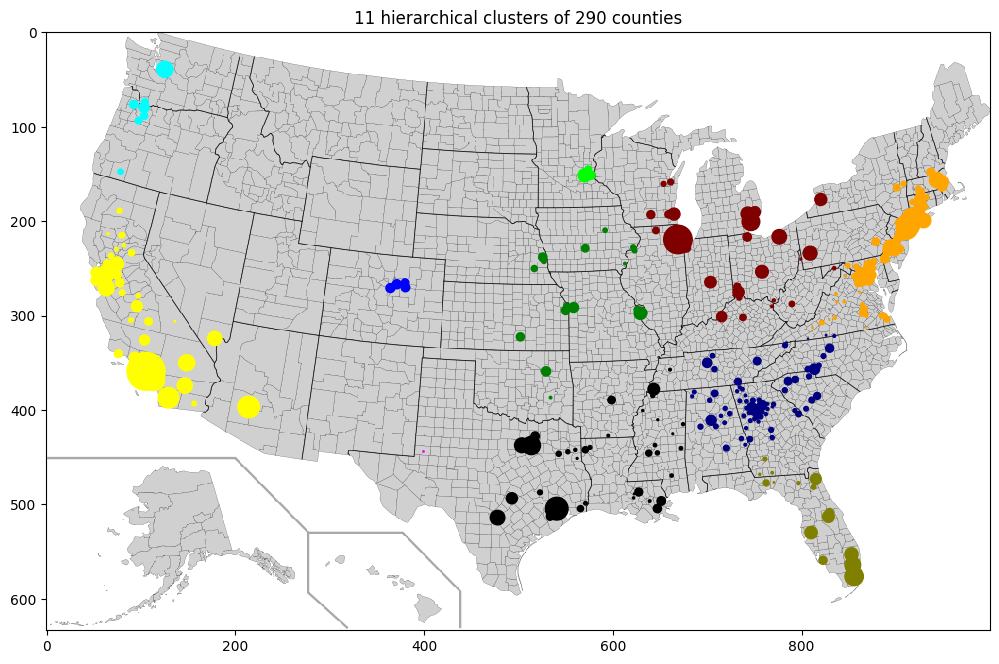

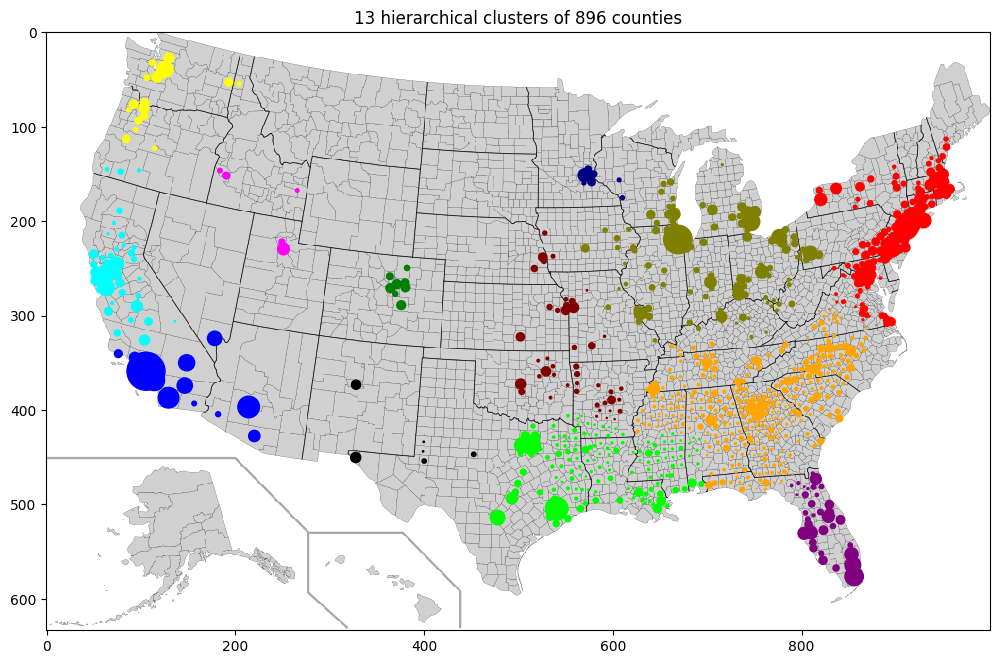

In [38]:
#############################################################
# Student code to plot several hierarchical clusterings (peer-graded)

def plot_hierarchical_clusterings():
    """ Plot some hierarchical clusterings """

    # Clustering for 111 high-risk counties (tested by the machine grader)
    risk_frame_111 = provided.risk_csv_to_dataframe(provided.DATA_111)
    singleton_clusters = provided.dataframe_to_singleton_clusters(risk_frame_111)
    clusters_111_9 = hierarchical_clustering(singleton_clusters, 9)
    provided.plot_clusters_members(clusters_111_9, risk_frame_111, 
                                   title="9 hierarchical clusters of 111 counties", 
                                   save_plot=SAVE_PLOTS)
    
    # Clustering for 290 high-risk counties (tested by the machine grader)
    risk_frame_290 = provided.risk_csv_to_dataframe(provided.DATA_290)
    singleton_clusters = provided.dataframe_to_singleton_clusters(risk_frame_290)
    clusters_290_11 = hierarchical_clustering(singleton_clusters, 11)
    provided.plot_clusters_members(clusters_290_11, risk_frame_290, 
                                   title="11 hierarchical clusters of 290 counties", 
                                   save_plot=SAVE_PLOTS)
    
    # Clustering for 896 high-risk counties (not tested by the machine grader)
    risk_frame_896 = provided.risk_csv_to_dataframe(provided.DATA_896)
    singleton_clusters = provided.dataframe_to_singleton_clusters(risk_frame_896)
    clusters_896_13 = hierarchical_clustering(singleton_clusters, 13)
    provided.plot_clusters_members(clusters_896_13, risk_frame_896, 
                                   title="13 hierarchical clusters of 896 counties", 
                                   save_plot=SAVE_PLOTS)
    
    # Clustering for 3108 (not tested by the machine grader) - 5 minutes to compute on desktop
    #risk_frame_3108 = provided.risk_csv_to_dataframe(provided.DATA_3108)
    #singleton_clusters = provided.dataframe_to_singleton_clusters(risk_frame_3108)
    #clusters_3108_15 = hierarchical_clustering(singleton_clusters, 15)
    #provided.plot_clusters_members(clusters_3108_15, risk_frame_3108, 
    #                               title="15 hierarchical clusters of 3108 counties", 
    #                               save_plot=SAVE_PLOTS)
    
# Default DPI for notebook graphics is 72, override for higher resolution images
mpl.rcParams['figure.dpi'] = 100

plot_hierarchical_clusterings()